In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ['R_HOME'] = r'C:\Program Files\R\R-3.4.4'
%matplotlib inline
%load_ext rpy2.ipython

In [2]:
%%R
install.packages('tidyverse')
library(tidyverse)
install.packages('corrplot')
library(corrplot)

In [3]:
data = pd.read_csv('./historic_data.csv')
train, test = data.iloc[0:int(len(data)*.9), :], data.iloc[int(len(data)*.9):, :]
train.head()

,date,hour,month,day_of_week,sunrise,icon,precip_prob,temperature,humidity,wind_speed,rides
0,2013-06-01,0,6,7,0,clear,0.01,77.65,0.61,2.06,152
1,2013-06-01,1,6,7,0,clear,0.01,75.62,0.67,1.93,102
2,2013-06-01,2,6,7,0,clear,0.01,74.72,0.70,2.31,67
3,2013-06-01,3,6,7,0,clear,0.01,73.32,0.76,2.16,41
4,2013-06-01,4,6,7,0,clear,0.01,72.42,0.79,1.93,16


There is no missing data, no odd or outlier information

In [4]:
train.describe()

,hour,month,day_of_week,sunrise,precip_prob,temperature,humidity,wind_speed,rides
count,35835.000000,35835.000000,35835.000000,35835.000000,35835.000000,35835.000000,35835.000000,35835.000000,35835.000000
mean,11.499009,6.559537,3.997321,0.511734,0.075633,55.020063,0.656553,3.356979,1260.184903
std,6.922825,3.384727,2.001616,0.499869,0.206868,20.351459,0.175933,2.247972,1255.227108
min,0.000000,1.000000,1.000000,0.000000,0.000000,-12.990000,0.140000,0.000000,1.000000
25%,5.000000,4.000000,2.000000,0.000000,0.000000,39.550000,0.520000,1.560000,224.000000
50%,11.000000,7.000000,4.000000,1.000000,0.000000,56.980000,0.660000,2.970000,895.000000
75%,17.000000,9.000000,6.000000,1.000000,0.000000,71.160000,0.800000,4.720000,1939.000000
max,23.000000,12.000000,7.000000,1.000000,1.000000,111.110000,1.000000,26.070000,7731.000000


Our predictors are:

- date (year, maybe?)
- hour
- month (categorical)
- day_of_week (categorical)
- sunrise (categorical)
- icon (categorical)
- precipitation_probability
- apparent temperature
- humidity
- windspeed

The response variable is:
- rides per hour

<h1>precip_prob</h1>

`precip_prob` is a continuous variable that ranges from 0 to 1 representing the decimal form probability that it will rain in this hour. Unsurprisingly, as the probability of rain increases, the number of rides in that hour decreases.

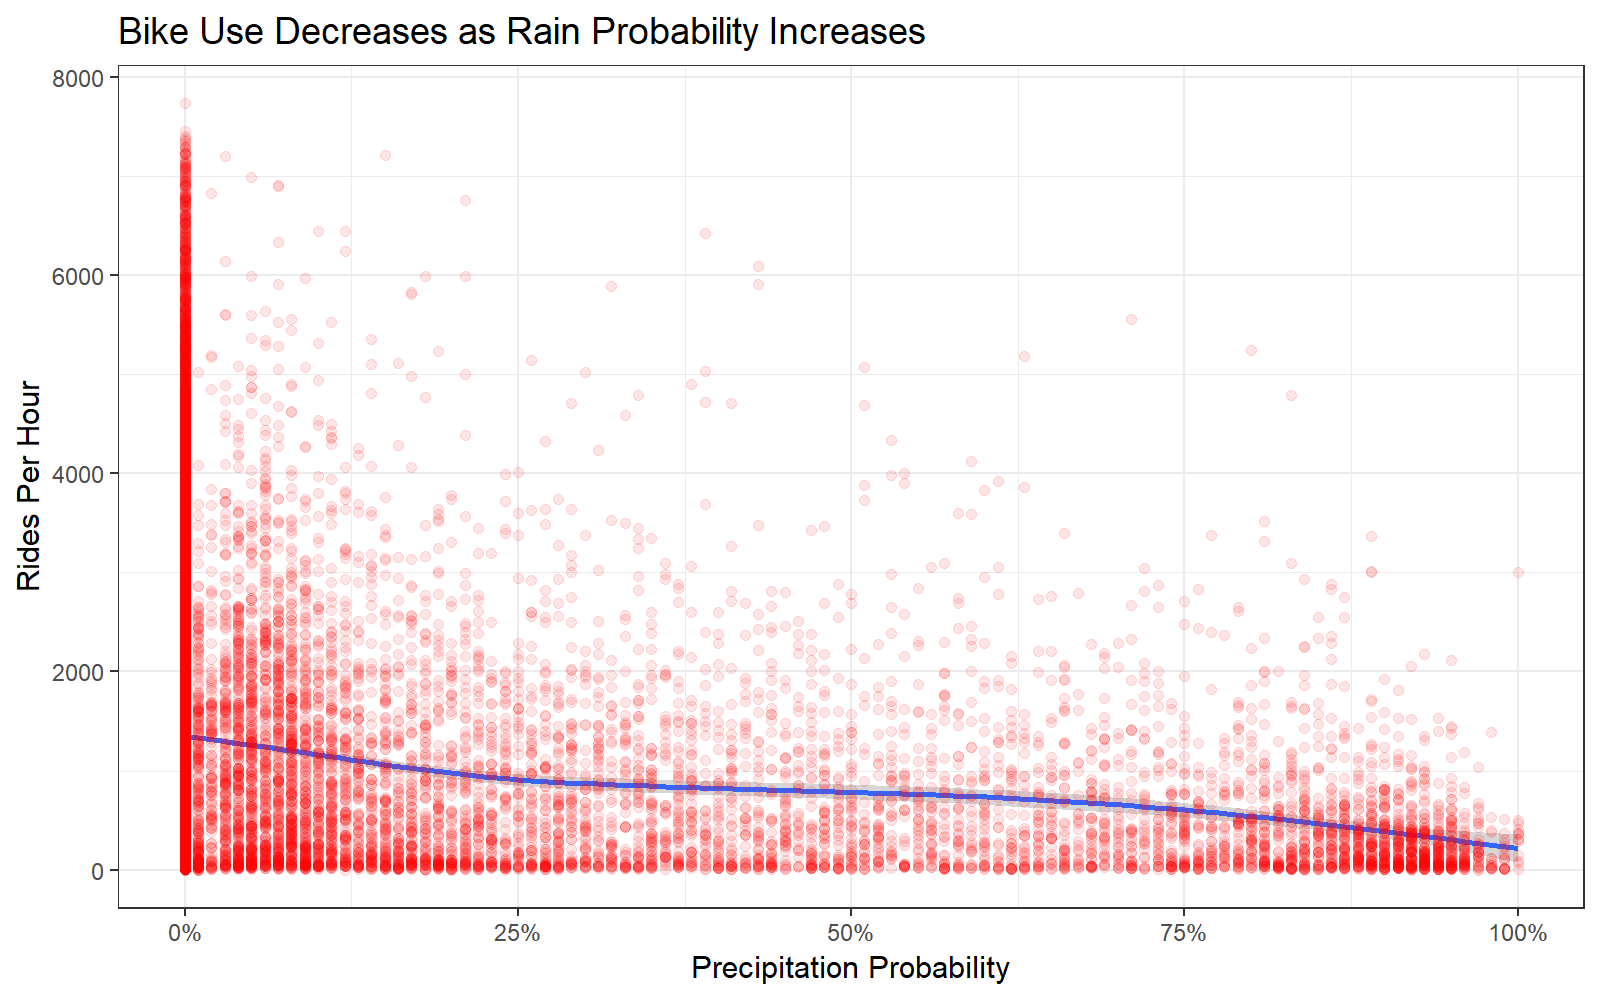

In [6]:
%%R -i train -w 8 -h 5 --units in -r 200
train %>%
  ggplot(aes(precip_prob, rides)) +
  geom_smooth() +
  geom_point(alpha=0.1, color='red') +
  labs(x='Precipitation Probability', 
       y='Rides Per Hour',
       title='Bike Use Decreases as Rain Probability Increases') +
  theme_bw() +
  scale_x_continuous(labels = scales::percent) 

<h1>temperature</h1>

`temperature` is a continuous variable representing the apparent temperature for the hour in degrees fahrenheit. It ranges from -12.99 to 111.11

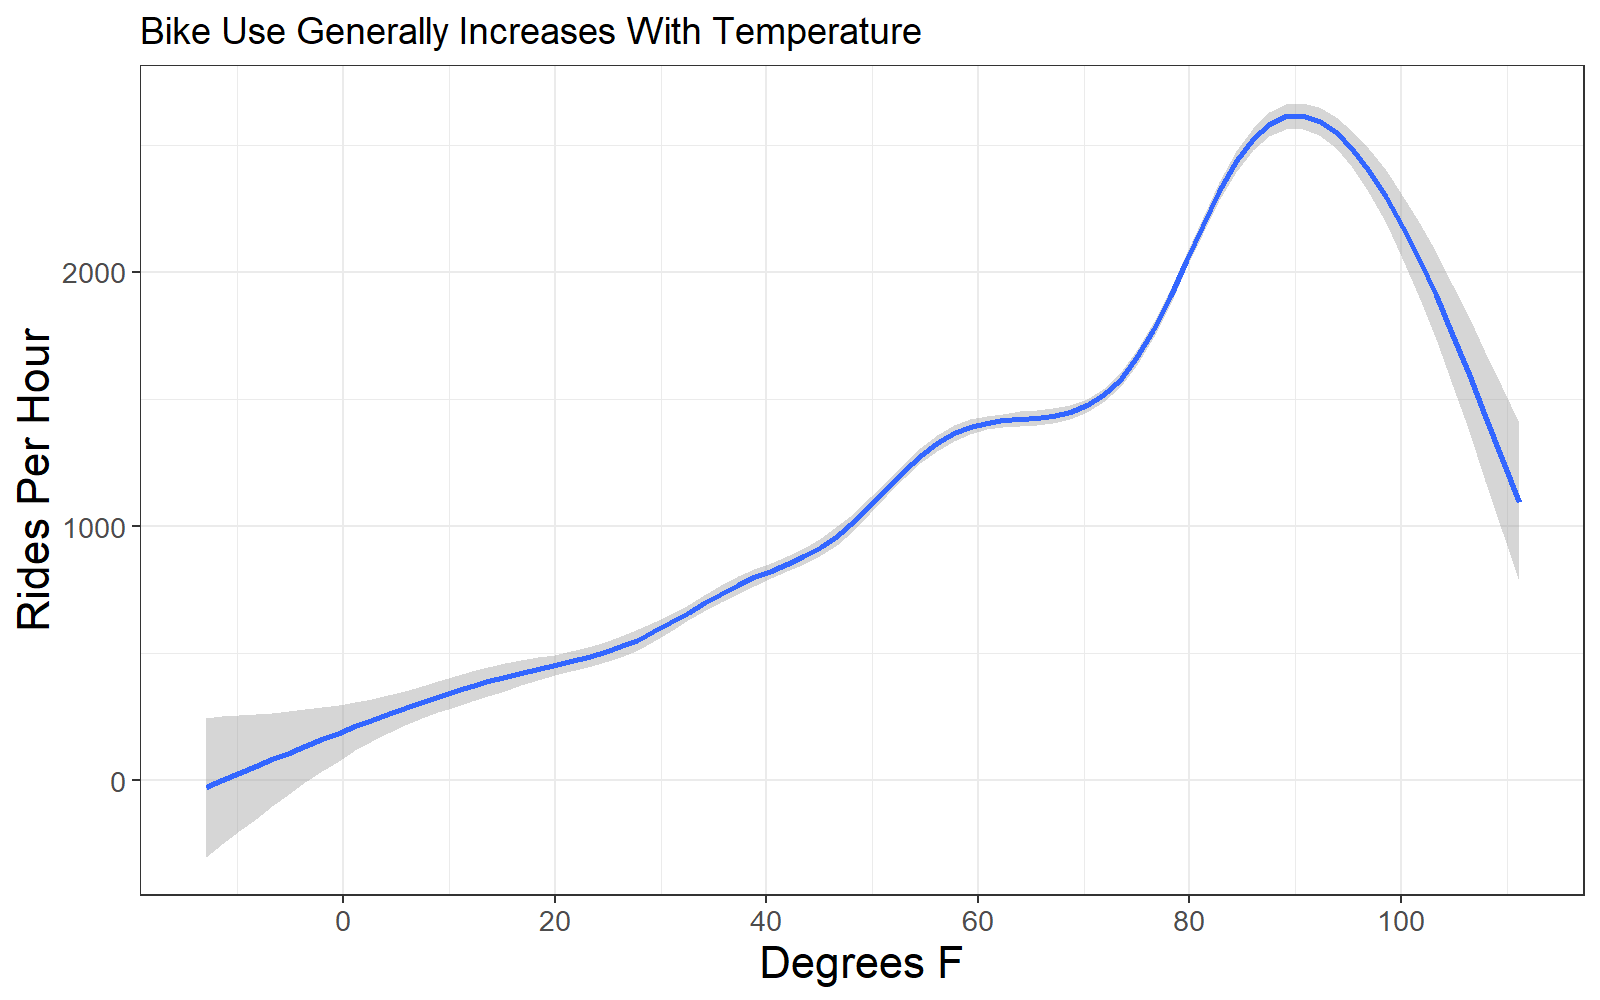

In [16]:
%%R -i train -w 8 -h 5 --units in -r 200
train %>%
  ggplot(aes(temperature, rides)) +
  geom_smooth() +
  labs(x='Degrees F', 
       y='Rides Per Hour',
       title='Bike Use Generally Increases With Temperature') +
  theme_bw() +
  scale_x_continuous(labels=seq(-20, 120, 20), breaks=seq(-20, 120, 20)) +
  theme(axis.title = element_text(size=16),
        axis.text = element_text(size=10))

<h1>Humidity</h1>

`humidity` is a continuous variable that ranges from 0 to 1 and describes how much water is in the air. High humidity can make it harder to breathe and thus less likely to ride a bike. Humidity is generally associated with other weather predictors such as high temperature and rain.

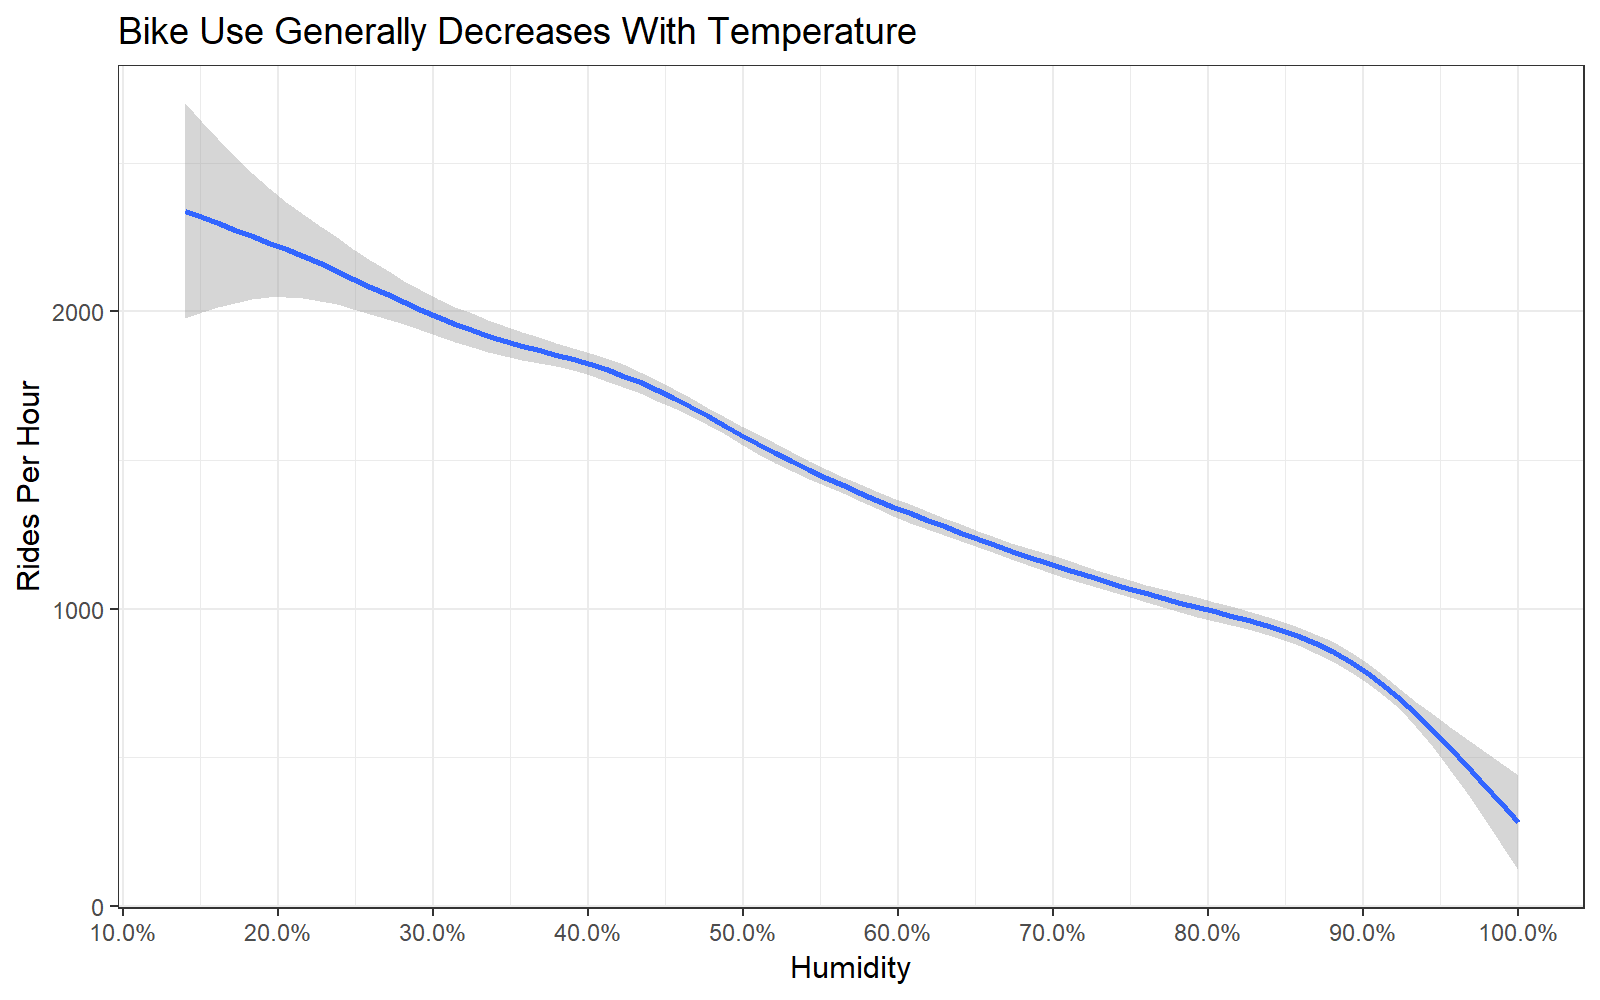

In [10]:
%%R -i train -w 8 -h 5 --units in -r 200
train %>%
  ggplot(aes(humidity, rides)) +
  geom_smooth() +
  labs(x='Humidity', 
       y='Rides Per Hour',
       title='Bike Use Generally Decreases With Temperature') +
  theme_bw() +
  scale_x_continuous(labels = scales::percent, breaks=seq(0, 1, .1)) 

<h1>wind speed</h1>

Wind speed can make riding a bike uncomfortably cold or even dangerous. However, when plotted, wind speed appears to have very little predictive ability for average number of rides. The wide confidence interval on the right is due to the overall lack of observations in this range. 

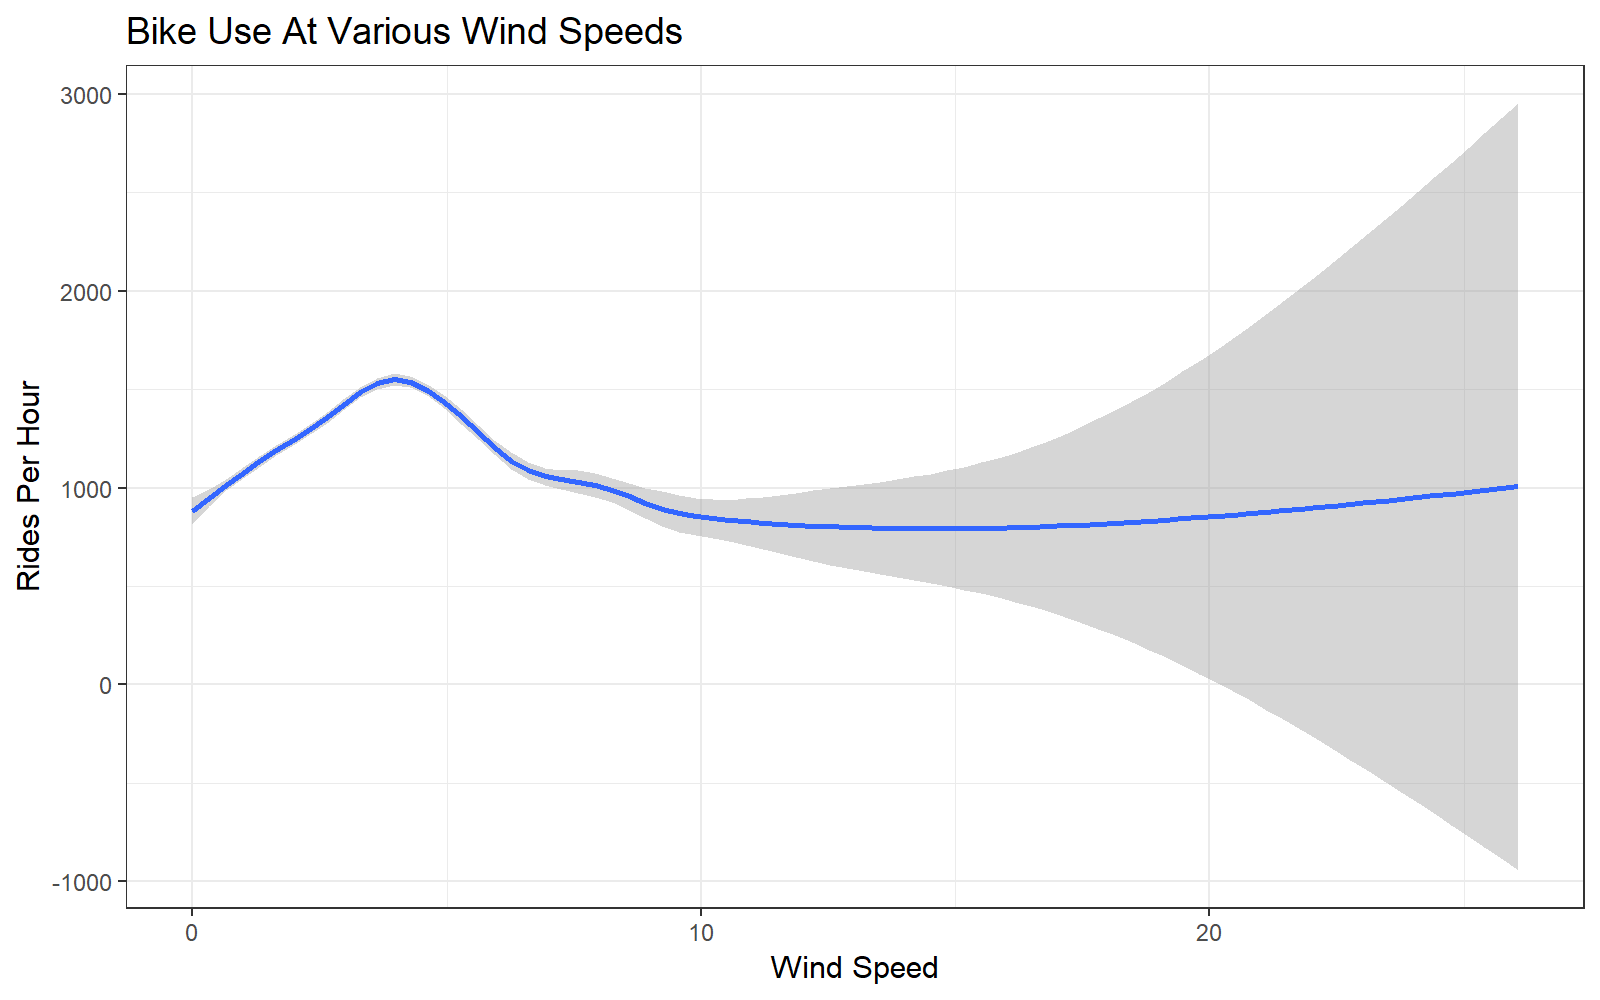

In [12]:
%%R -i train -w 8 -h 5 --units in -r 200
train %>%
  ggplot(aes(wind_speed, rides)) +
  geom_smooth() +
  labs(x='Wind Speed', 
       y='Rides Per Hour',
       title='Bike Use At Various Wind Speeds') +
  theme_bw()

<h2>Continuous Variables</h2>

Finally, let's look at the distributions of the four continuous variables. Here we can see that precip_prob is heavily skewed, owing to the fact that at most times of the day it is not raining. win_speed also have a few upper outliers while humidity and temperature are more evenly distributed.

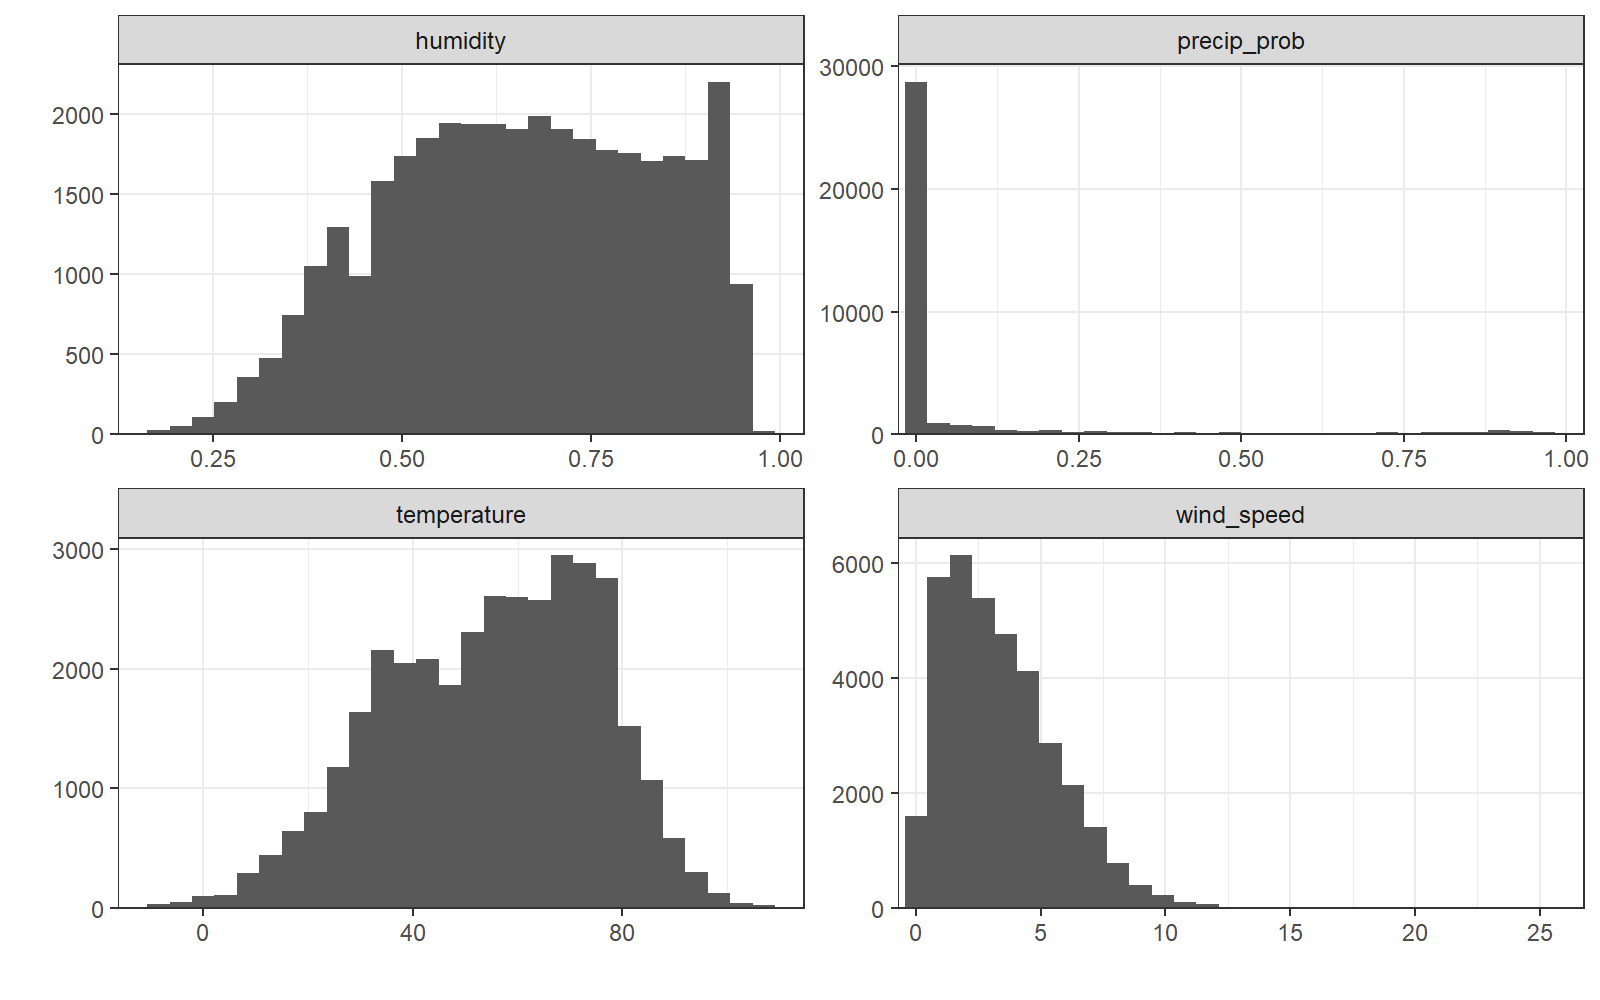

In [13]:
%%R -i train -w 8 -h 5 --units in -r 200
train %>%
  select_if(is.numeric) %>%
  select(-c(rides, day_of_week, hour, month, sunrise)) %>%
  gather(key='key', value='value') %>%
  ggplot(aes(value)) +
  geom_histogram() +
  facet_wrap(~key, scales='free') + 
  scale_x_continuous(expand=c(0.01, 0, 0.01, 0)) +
  scale_y_continuous(expand=c(0, 0, 0.05, 0.1)) +
  labs(x='', y='') +
  theme_bw() + 
  theme(panel.grid.minor.y = element_blank())

<h1>Month and Year</h1>

While `month` and `year` themselves are unlikely to have any effect on the number of rides, they both are great proxy's for a number of other predictors that may be hard to capture.

For `year` there is a general upward trend is use in the Citi Bike program. This is a result of the increasing prominence of stations around the city and growing popularity of the program

`month` captures weather trends like temperature, but can also capture concepts like summer, holidays and vacations.

Most intersting is how month captures an apparent rhythm or habit of riding a bike. Comparing historical weather patterns in New York we find that the average weather in October is <b>colder</b> than in May and yet the number of rides are consistently higher. In fact, the weather in April is often nicer than October and it lags very far behind. This indicates that there is a bit of a habit in biking. People are slow to pick it up in the Spring (after taking the winter off) but then are slow to give it up as the weather cools again. This paints a positive picture of biking as something people find useful. 

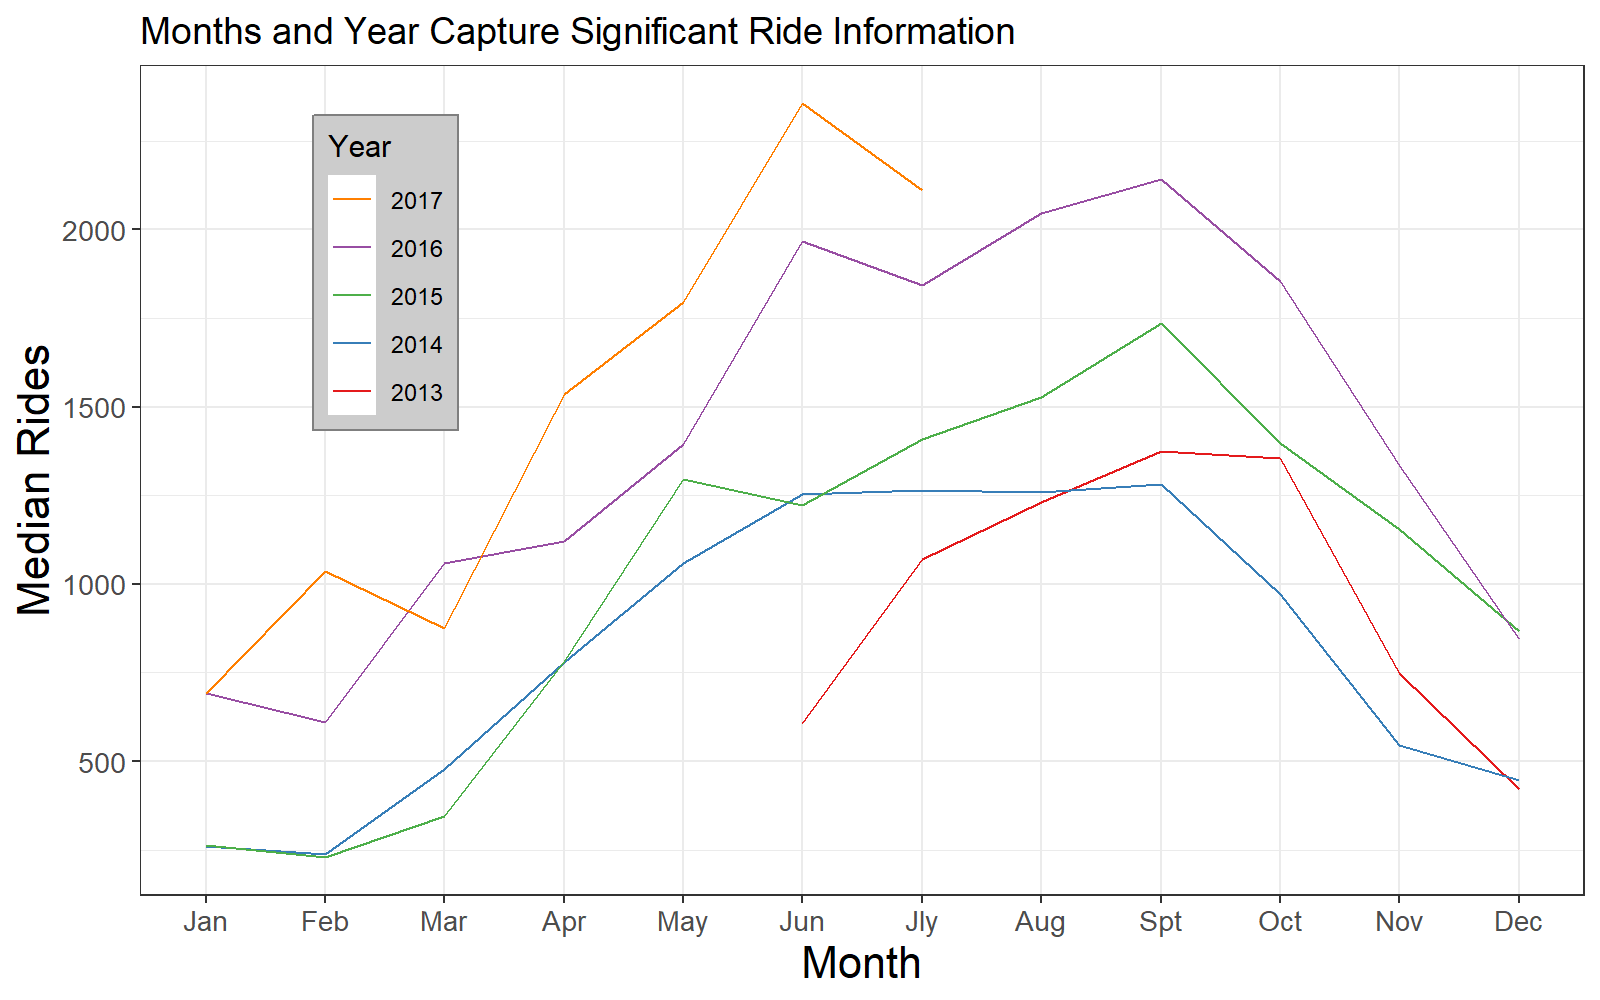

In [23]:
%%R -i train -w 8 -h 5 --units in -r 200

train %>%
  mutate(year = substr(date, 0, 4)) %>%
  group_by(year, month) %>%
  summarise(total = median(rides)) %>%
  ggplot(aes(month, total, color=year)) + 
  geom_line() +
  labs(x='Month', 
       y='Median Rides',
       title='Months and Year Capture Significant Ride Information',
       color='Year') +
  scale_color_brewer(palette='Set1')  +
  scale_x_continuous(labels=c('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jly', 'Aug', 'Spt', 'Oct', 'Nov', 'Dec'),
                     breaks=seq(1, 12)) +
  theme_bw() +
  theme(panel.grid.minor.x = element_blank(),
        legend.background = element_rect(color='grey50', fill='grey80'),
        legend.spacing = unit(0.4, 'npc'),
        legend.position = c(0.17, 0.75),
        axis.title = element_text(size=16),
        axis.text = element_text(size=10)) +
  guides(color=guide_legend(reverse=T)) 

<h1>Hour</h1>

Hour of the day (from 0 to 23) is a very useful metric. As one would anticipate, the bike at utilized more during work hours than during the night. The data is also bimodal during morning and afternoon rush hour. This indicates that a significant portion of riders are commuters and not tourists. 

Also note how the data is quite cyclic with hour 23 smoothly transitioning into hour 0 of the next day.

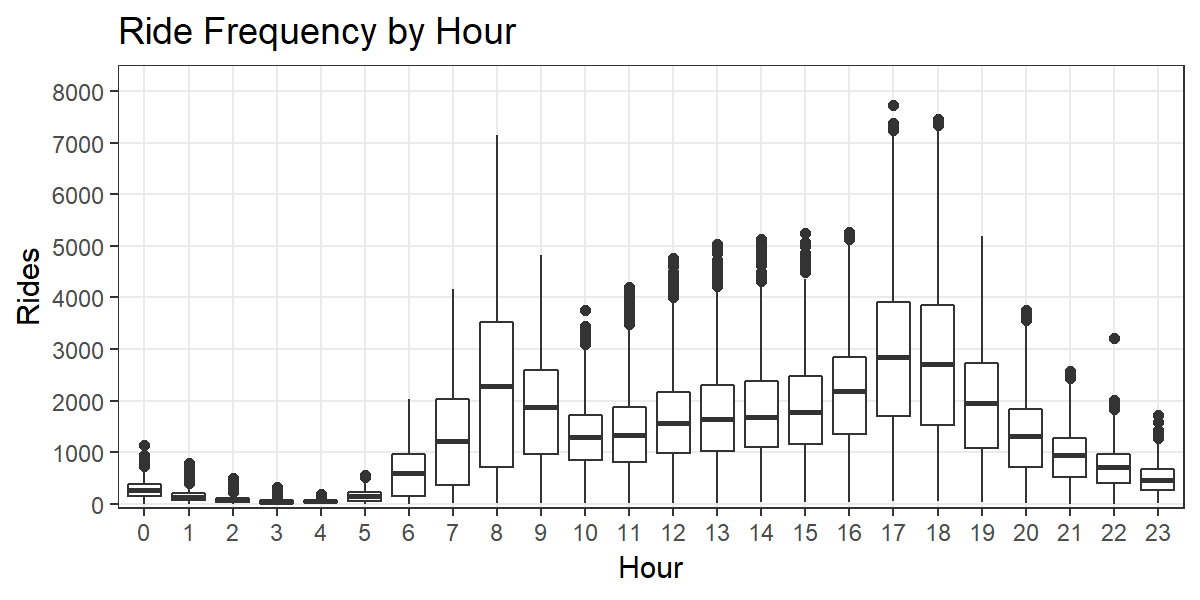

In [26]:
%%R -i train -w 6 -h 3 --units in -r 200
train %>%
  mutate(hour = as.factor(hour)) %>%
  ggplot(aes(hour, rides)) +
  geom_boxplot() +
  scale_y_continuous(labels=seq(0, 9000, 1000), breaks=seq(0, 9000, 1000), expand=c(0.01, 0.1, 0.1, 0)) +
  labs(title='Ride Frequency by Hour',
       x='Hour',
       y='Rides') +
  theme_bw() +
  theme(panel.grid.minor.y = element_blank()) 

<h1>Day of Week</h1>

The day of week variable providing interesting results. I had originally anticipated that weekends would have the highest usaged but it appears to be the exact opposite of that. This chart, combined with the previous plot that shows spikes during morning and evening rush hour make a compelling case that the bikes are heavily used by locals commuting to and from work.

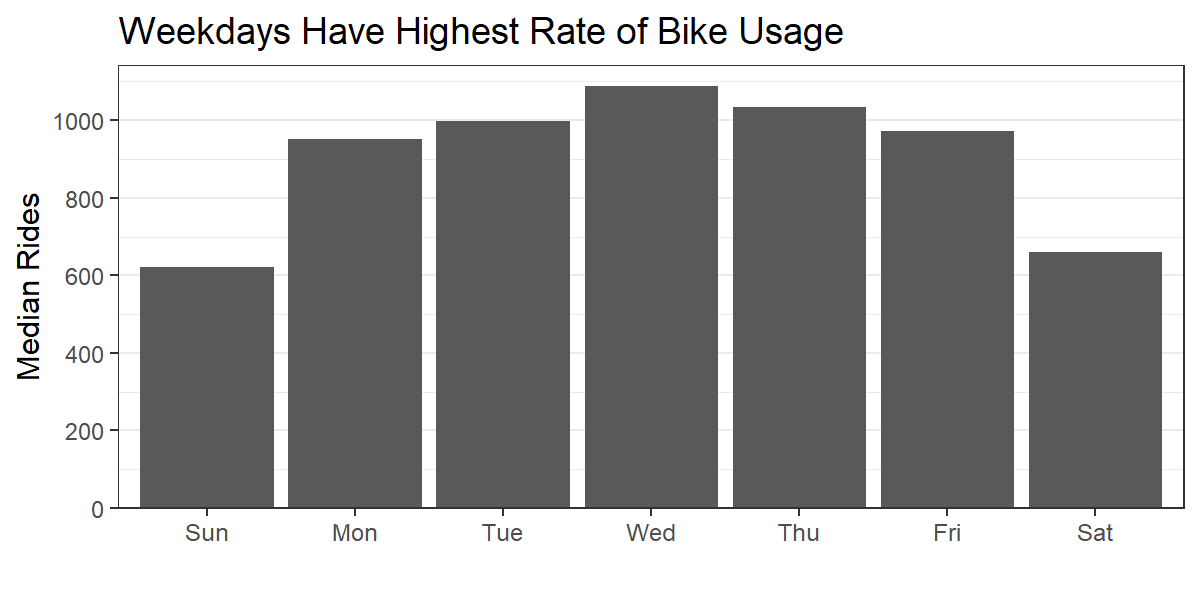

In [18]:
%%R -i train -w 6 -h 3 --units in -r 200
train %>%
  mutate(day_of_week = as.factor(day_of_week)) %>%
  group_by(day_of_week) %>%
  summarize(total = median(rides)) %>%
  ggplot(aes(day_of_week, total)) +
  geom_histogram(stat='identity') +
  scale_x_discrete(labels=c('Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat')) +
  scale_y_continuous(labels=seq(0, 1500, 200), breaks=seq(0, 1500, 200), expand=c(0, 0, 0.05, 0)) +
  labs(title='Weekdays Have Highest Rate of Bike Usage',
       y='Median Rides',
       x='') +
  theme_bw() +
  theme(panel.grid.major.x = element_blank())

<h1>Sunrise</h1>

Sunrise is a boolean variable representing whether the sun is up or down. This variable may offer additional insight that hour of day cannot. People are more likely to bike when the sun is up and that time of day will shift throughout the year.

The plot shows the effect of the sun being up is minimal. Despite their relative size differences, there is a consistent daily pattern in bike usage numbers. In the months when hour shift from the sun being up to being down we do not see any significant change in activity.

November has clearly anomalous data. This is due to a quirk in daylight time. Specifically, November often only has 1 or 2 days each year where the sun is up at 5pm and thus these numbers are greatly inflated. Once standardized, there is no major difference.

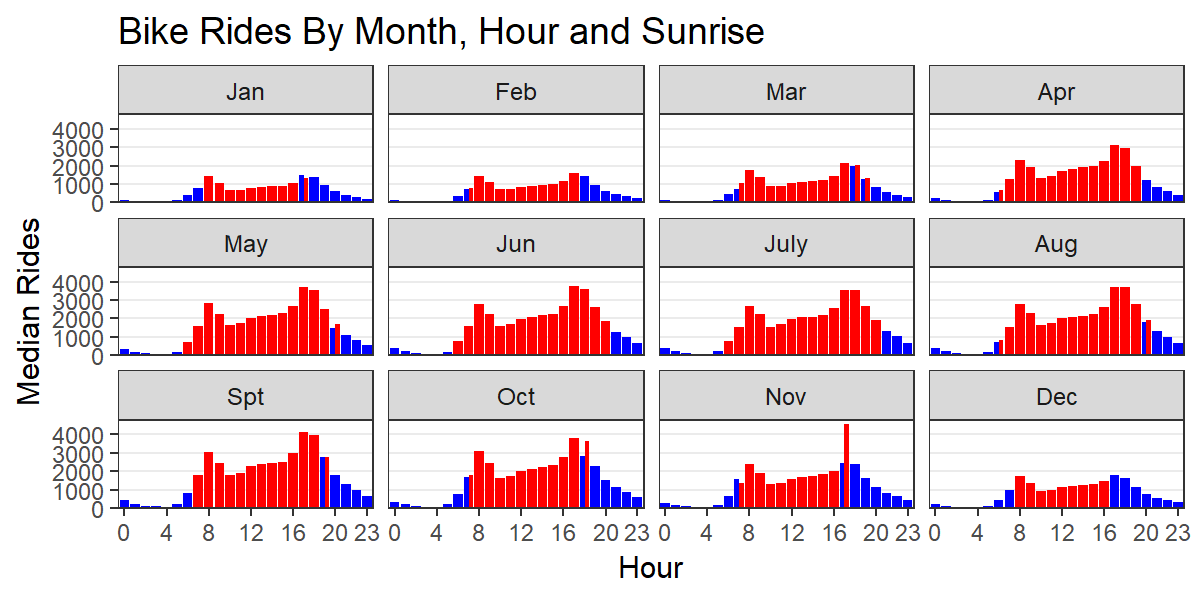

In [23]:
%%R -i train -w 6 -h 3 --units in -r 200

facets <- list(
    '1'='Jan',
    '2'='Feb',
    '3'='Mar',
    '4'='Apr',
    '5'='May',
    '6'='Jun',
    '7'='July',
    '8'='Aug',
    '9'='Spt',
    '10'='Oct',
    '11'='Nov',
    '12'='Dec'
)

facets_labeller <- function(variable,value){
  return(facets[value])
}

train %>%
  mutate(sunrise = as.factor(sunrise),
         hour = as.factor(hour)) %>%
  group_by(month, hour, sunrise) %>%
  summarize(total = mean(rides)) %>%
  ggplot(aes(hour, total, fill=sunrise)) +
  geom_bar(position='dodge', stat='identity') +
  facet_wrap(~month, labeller=facets_labeller) + 
  scale_fill_manual(values=c('blue', 'red'), guide=FALSE) +
  scale_y_continuous(expand=c(0, 0, 0.05, 0), labels=seq(0, 5000, 1000), breaks=seq(0, 5000, 1000)) +
  scale_x_discrete(breaks = c(0, 4, 8, 12, 16, 20, 23)) +
  labs(title='Bike Rides By Month, Hour and Sunrise', 
       x='Hour',
       y='Median Rides') +
  theme_bw() +
  theme(panel.grid.minor = element_blank(),
        panel.grid.major.x = element_blank())

<h1>Icon

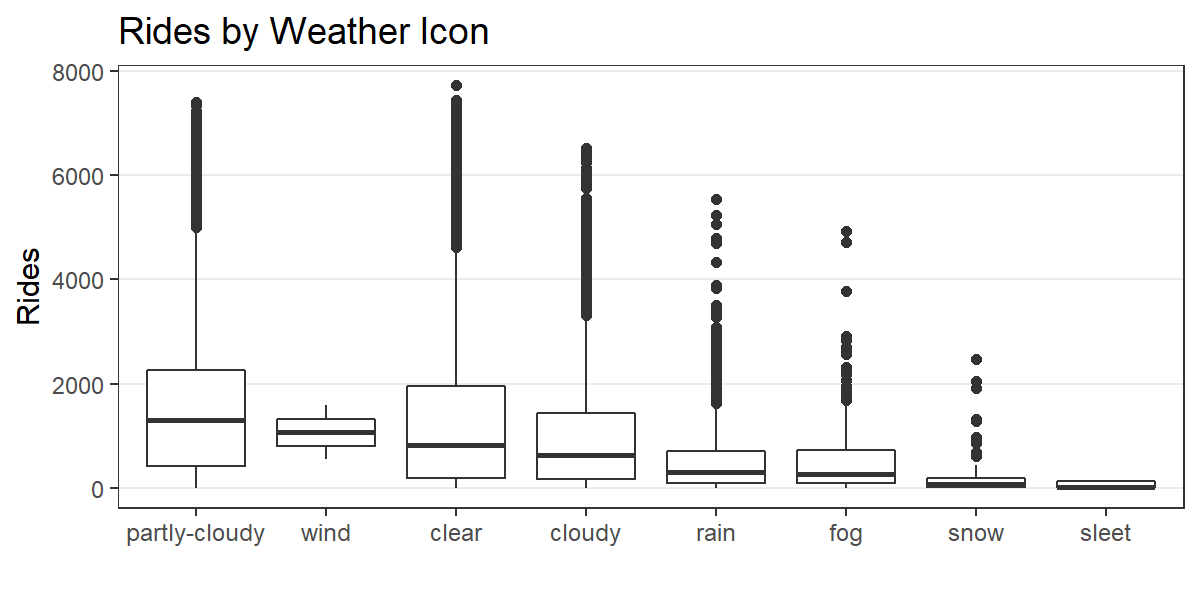

In [32]:
%%R -i train -w 6 -h 3 --units in -r 200

train %>%
  ggplot(aes(reorder(icon, -rides, median, order=TRUE), rides)) +
  geom_boxplot() +
  labs(x='', y='Rides', title='Rides by Weather Icon') +
  theme_bw() +
  theme(panel.grid.minor = element_blank(),
        panel.grid.major.x = element_blank())

<h1>Correlation</h1>

There are numerous weather related predictors and it is likely that some of them overlap. For example, the temperature is likely to be higher when the sun is up. 

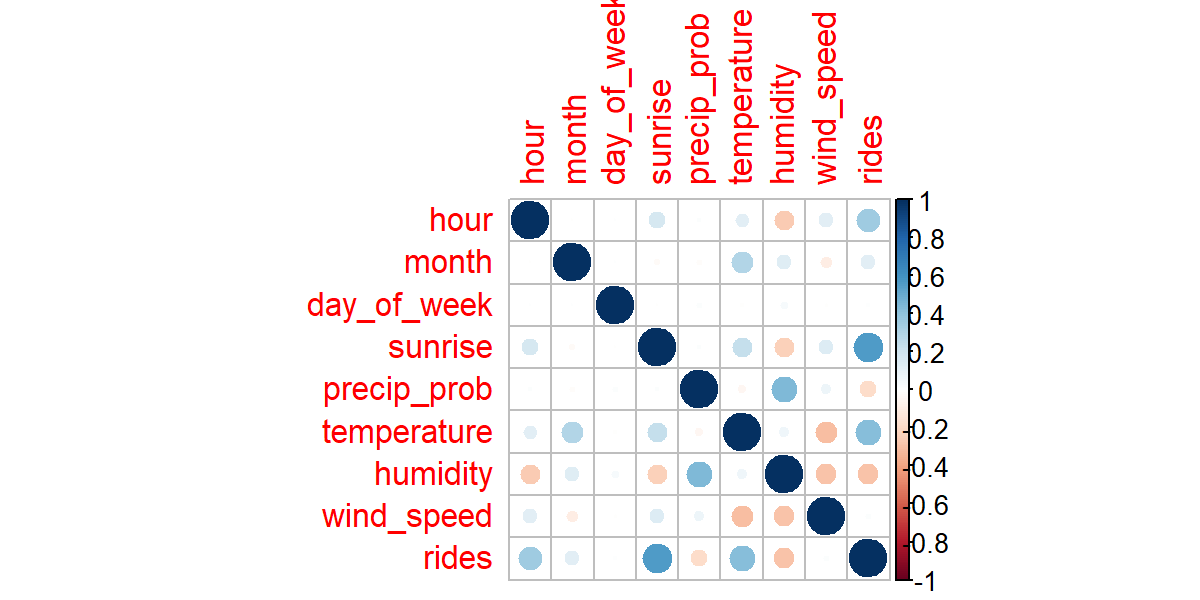

In [22]:
%%R -i train -w 6 -h 3 --units in -r 200

train %>%
  select_if(is.numeric) %>%
  cor() %>%
  corrplot(method='circle')

<h1>Rides</h1>

Finally, rides shows a very heavy skew in the number of rides. This may be an issue depending on the machine learning model that is ultimately used. 

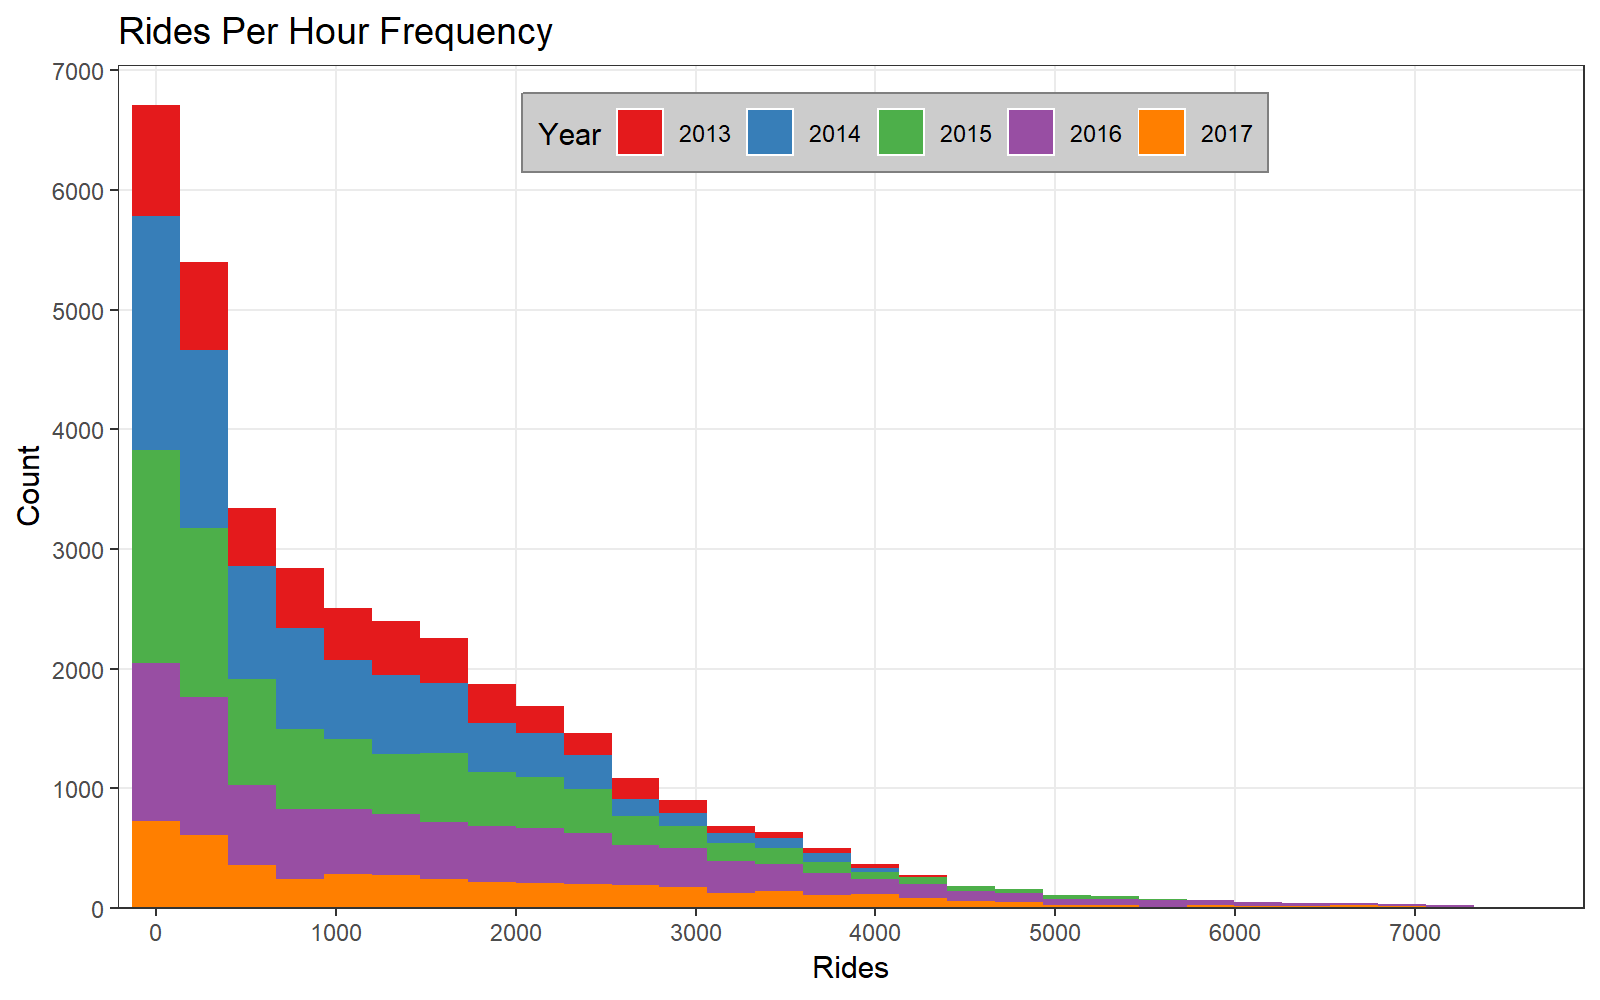

In [34]:
%%R -i train -w 8 -h 5 --units in -r 200
train %>%
  mutate(year = substr(date, 0, 4)) %>%
  ggplot(aes(rides, fill=year)) +
  geom_histogram() +
  labs(title='Rides Per Hour Frequency',
       x='Rides',
       y='Count',
       fill='Year') +
  scale_fill_brewer(palette='Set1') +
  scale_y_continuous(labels=seq(0, 7000, 1000), breaks=seq(0, 7000, 1000), expand=c(0, 0, 0.05, 0)) +
  scale_x_continuous(labels=seq(0, 8000, 1000), breaks=seq(0, 8000, 1000), expand=c(0.01, 0, 0.01, 0)) +
  theme_bw() +
  theme(panel.grid.minor = element_blank(),
        legend.background = element_rect(color='grey50', fill='grey80'),
        legend.spacing = unit(0.4, 'npc'),
        legend.position = c(0.53, 0.92),
        legend.direction = 'horizontal',
        axis.title = element_text(size=16),
        axis.text = element_text(size=10)))